In [1]:


from slp.data.isolated_supervised import load_dataset
from slp.config.templates.data import RecognitionDatasetConfig, DataPreprocessing, DataLoaderConfig
from slp.config.templates.model import ModelConfig
from slp.nn.loading import load_backbone

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sign_language_tools.player.video_player import VideoPlayer
from sign_language_tools.pose.mediapipe.edges import UPPER_POSE_EDGES, HAND_EDGES

import torch
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
root = "Z:/data/lsfb/lsfb-isol"
dataset, _ = load_dataset(RecognitionDatasetConfig(
    shards_url=f"file:{root}/shards/500/shard_000000.tar",
    preprocessing=DataPreprocessing(
        pose_transform_pipeline="concat+resample-linear+rgb-img",
        input_type='rgb',
        # include_videos=True,
    ),
))
visualization_dataset, _ = load_dataset(RecognitionDatasetConfig(
    shards_url=f"file:{root}/shards/500/shard_000000.tar",
    preprocessing=DataPreprocessing(
        pose_transform_pipeline="none",
    ),
))

len(dataset)

Loading instances from shards: file:Z:/data/lsfb/lsfb-isol/shards/500/shard_000000.tar
Dataset loaded: 18202 instances.
Loading instances from shards: file:Z:/data/lsfb/lsfb-isol/shards/500/shard_000000.tar
Dataset loaded: 18202 instances.


18202

In [3]:
def display_rgb_image(rgb_img, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-20, 63)
    ax.imshow(rgb_img)
    ax.hlines([22.5, 22.5+21], xmin=-20, xmax=64, color='black')
    ax.text(-18, 11, 'Body', fontsize=12)
    ax.text(-18, 22+11, 'Left hand', fontsize=12)
    ax.text(-18, 22+21+11, 'Right hand', fontsize=12)

def display_sample(sample):
    display_rgb_image(sample['poses'].permute(1, 2, 0).numpy())
    player = VideoPlayer()
    player.attach_video(f"{root}/videos/{sample['id']}.mp4")
    player.play(speed=0.1)

In [ ]:
sample_indices = dataset.get_sample_indices_for_class(22)
n_samples = len(sample_indices)
plt.figure()
display_sample(dataset[sample_indices[0]])  # NB. 1
plt.figure()
display_sample(dataset[sample_indices[n_samples//2]])
plt.figure()
display_sample(dataset[sample_indices[-1]])

In [ ]:
sample_indices = dataset.get_sample_indices_for_class(236)  # LIVRE
n_samples = len(sample_indices)
plt.figure()
display_sample(dataset[sample_indices[0]])
plt.figure()
display_sample(dataset[sample_indices[n_samples//2]])
plt.figure()
display_sample(dataset[sample_indices[-1]]) # NB. 2

In [ ]:
sample_indices = dataset.get_sample_indices_for_class(127)  # APPRENDRE
n_samples = len(sample_indices)
plt.figure()
display_sample(dataset[sample_indices[0]])
plt.figure()
display_sample(dataset[sample_indices[n_samples//2]])
plt.figure()
display_sample(dataset[sample_indices[-1]])

In [ ]:
sample_indices = dataset.get_sample_indices_for_class(171)  # INFORMER
n_samples = len(sample_indices)
plt.figure()
display_sample(dataset[sample_indices[0]])
plt.figure()
display_sample(dataset[sample_indices[n_samples//2]])
plt.figure()
display_sample(dataset[sample_indices[-1]])

In [22]:
def get_resnet50_gradcam(sample):
    model = load_backbone(ModelConfig(
        type='resnet50-2d',
        args=dict(pretrained=False, c_out=500, dropout=0.5)
    ))
    checkpoint = {
        k.replace('model.backbone.', ''): v
        for k, v in torch.load("Z:/data/lucia/slp/checkpoints/islr_lsfb500/r50/base/epoch=25-step=14820.ckpt", map_location='cpu', weights_only=True)['state_dict'].items()
        if k.startswith('model.backbone.')
    }
    model.load_state_dict(checkpoint)
    model.eval()
    target_layers = [model.resnet.layer4[-1]]
    input_tensor = sample['poses'].unsqueeze(0)
    targets = [ClassifierOutputTarget(sample['label_id'])]
    rgb_img = input_tensor[0].permute(1, 2, 0).cpu().numpy()
    with EigenGradCAM(model=model, target_layers=target_layers) as cam:
        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        # You can also get the model outputs without having to redo inference
        model_outputs = cam.outputs
    return grayscale_cam, visualization

In [33]:
def final_plot(sample, img_path):
    preview = Image.open(img_path)
    preview_array = np.array(preview)
    gradcam_img, _ = get_resnet50_gradcam(sample)

    plt.figure(figsize=(16, 4))
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(preview_array, aspect=1)
    plt.subplot(132)
    plt.title('RGB Representation')
    display_rgb_image(sample['poses'].permute(1, 2, 0).numpy())
    plt.subplot(133)
    plt.title('Grad-CAM')
    display_rgb_image(gradcam_img)
    plt.tight_layout()
    plt.show()

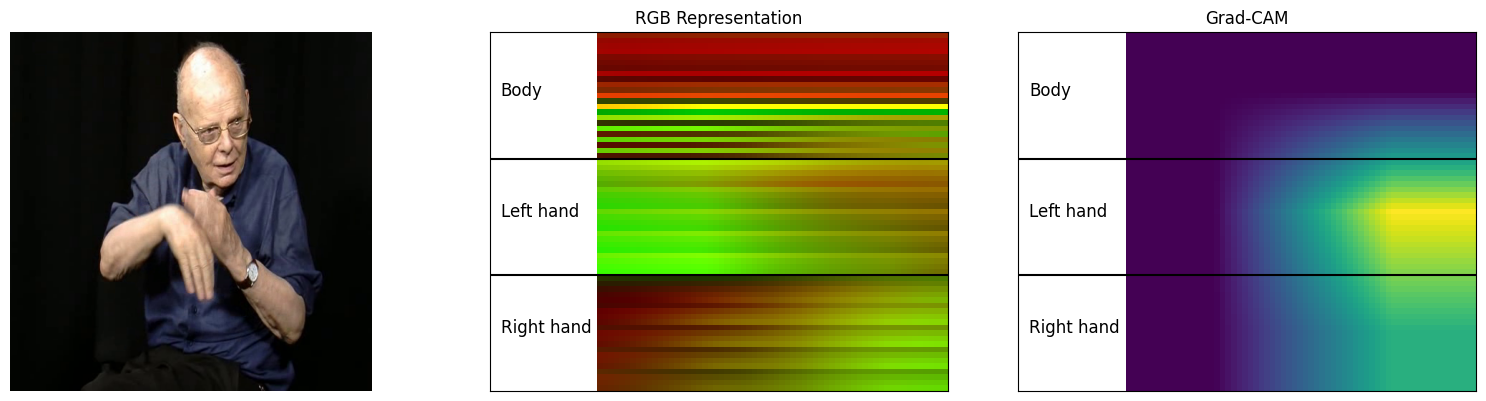

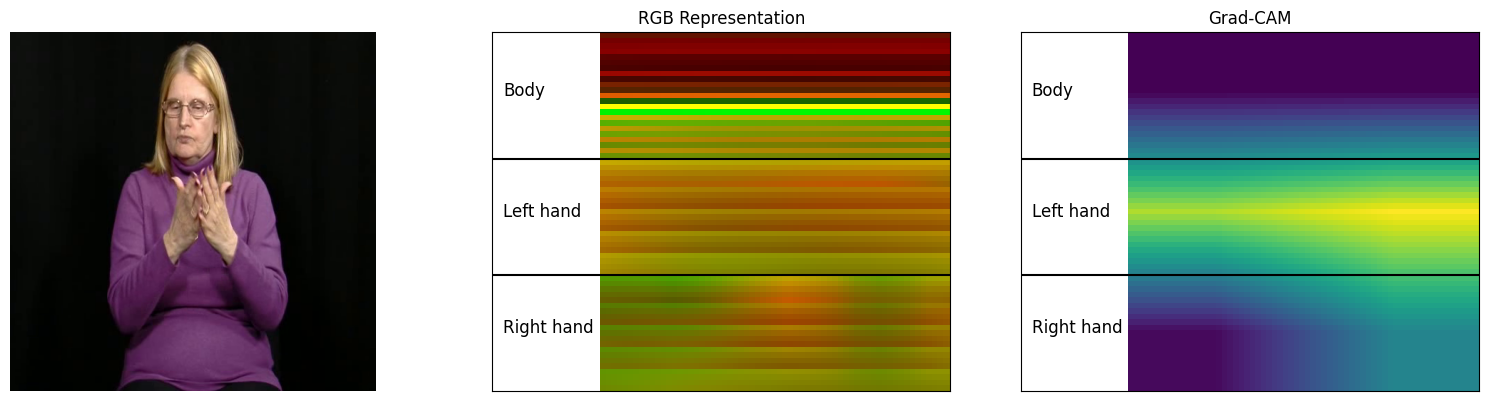

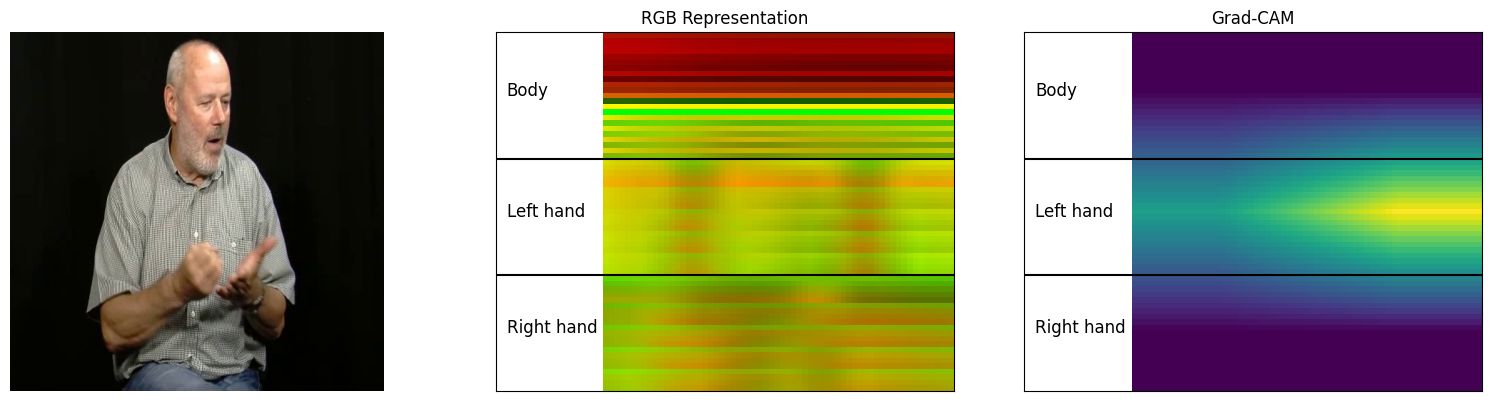

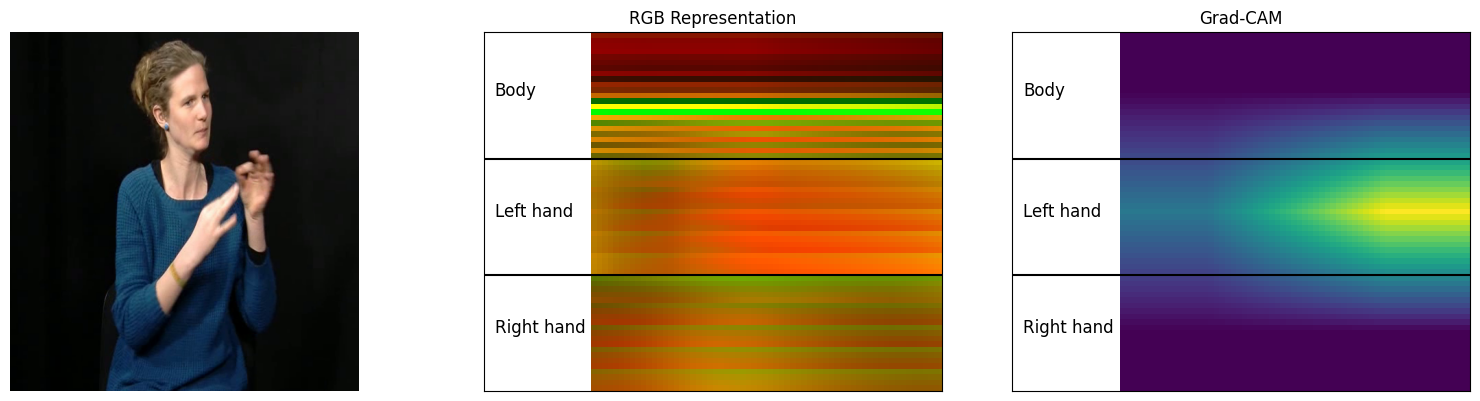

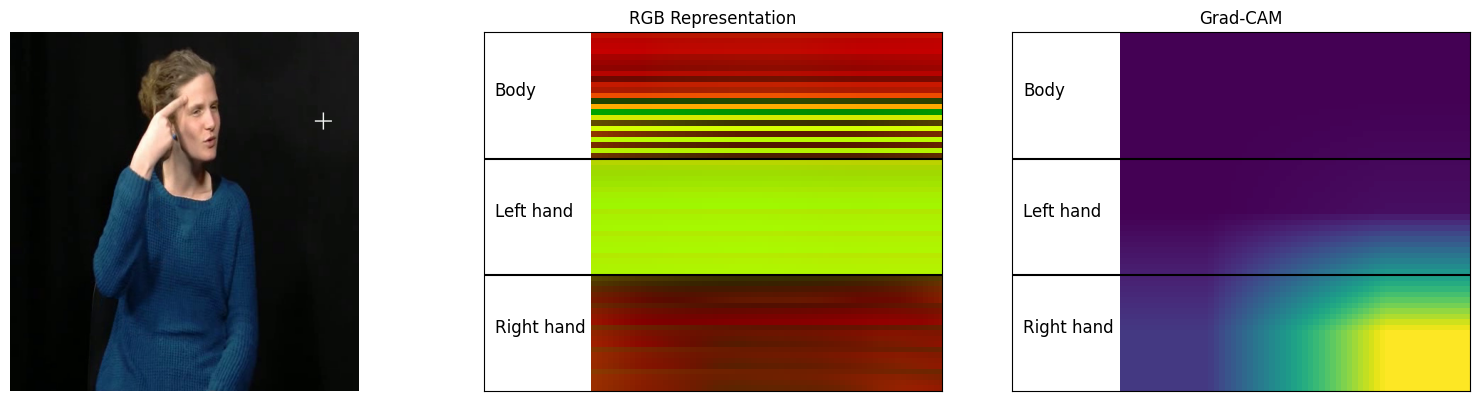

In [44]:
selected_samples = [
    (22, 0),
    (236, -1),
    (171, -1),
    (163, -1),
    (31, 52),
]

for label_id, sample_index in selected_samples:
    sample = dataset[dataset.get_sample_indices_for_class(label_id)[sample_index]]
    img_path = f'./img/{label_id}_{sample_index}.png'
    final_plot(sample, img_path)

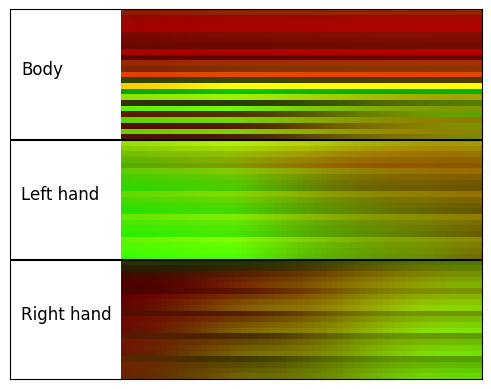

In [45]:
display_sample(dataset[dataset.get_sample_indices_for_class(22)[0]])